In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from data.dataset import BCDataset

import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx, subgraph
from collections import deque

from tqdm.auto import tqdm

import random

In [ ]:
# idata = BCDataset(type='elliptic', path='datasets/elliptic')
# print(idata.features.shape, idata.labels.shape, idata.edge_index.shape)

# # idata = BCDataset(type='ibm', path='datasets/ibm')
# # print(idata.features.shape, idata.labels.shape, idata.edge_index.shape)

# data = idata.get_pyg_data()

# data

torch.Size([203769, 166]) torch.Size([203769]) torch.Size([2, 234355])


Data(x=[203769, 166], edge_index=[2, 234355], y=[203769], train_mask=[203769], val_mask=[203769], test_mask=[203769])

In [3]:
def create_large_directed_graph(num_nodes=1000, avg_degree=10, feature_dim=2):
    """
    Create a large directed graph with random edges and attributes.
    
    Args:
        num_nodes: Number of nodes in the graph.
        avg_degree: Approximate average number of outgoing edges per node.
        feature_dim: Dimension of node features.
    
    Returns:
        Data: PyTorch Geometric Data object with edge_index, x, and edge_attr.
    """
    # Estimate number of edges based on average degree
    num_edges = num_nodes * avg_degree
    
    # Generate random directed edges
    edges = []
    for _ in tqdm(range(num_edges), desc="Generating edges"):
        u = random.randint(0, num_nodes-1)
        v = random.randint(0, num_nodes-1)
        if u != v and [u, v] not in edges:  # Avoid self-loops and duplicate edges
            edges.append([u, v])
    
    # Convert to edge_index tensor
    edge_index = torch.tensor(edges, dtype=torch.long).t()
    
    # Generate random node features
    x = torch.randn(num_nodes, feature_dim)
    
    # Generate random edge weights
    edge_attr = torch.randn(edge_index.size(1))
    
    # Create Data object
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [4]:
def visualize_pyg_graph(data: Data, title: str = "Subgraph Visualization", node_size: int = 500, 
                       node_color: str = 'lightblue', edge_color: str = 'gray', 
                       font_size: int = 12, figsize: tuple = (8, 6), 
                       show_edge_labels: bool = False):
    """
    Visualize a PyTorch Geometric Data object as a graph using NetworkX and Matplotlib.
    """
    G = to_networkx(data, to_undirected=True, edge_attrs=['edge_attr'] if data.edge_attr is not None else None)
    pos = nx.spring_layout(G)
    plt.figure(figsize=figsize)
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_color,
        node_size=node_size,
        font_size=font_size,
        font_weight='bold',
        edge_color=edge_color,
        width=2
    )
    if data.x is not None:
        node_labels = {i: f"Node {i}\n{data.x[i].tolist()}" for i in range(data.num_nodes)}
        nx.draw_networkx_labels(G, pos, font_size=font_size-2)
    if show_edge_labels and data.edge_attr is not None:
        edge_labels = {(u, v): f"{data.edge_attr[i].item():.2f}" 
                      for i, (u, v) in enumerate(data.edge_index.t().tolist())}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=font_size-2)
    plt.title(title)
    plt.show()

In [7]:
def extract_connected_subgraph(data, max_nodes=25, max_edges=40):
    """
    Extract a connected subgraph with up to max_nodes and max_edges using BFS.
    """
    G = to_networkx(data, to_undirected=False)
    max_attempts = 100

    for _ in tqdm(range(max_attempts), desc="Attempting to find connected subgraph"):
        start_node = random.choice(list(G.nodes))
        visited = set([start_node])
        queue = [start_node]
        edges = set()

        while queue and len(visited) < max_nodes and len(edges) < max_edges:
            current = queue.pop(0)
            for neighbor in G.neighbors(current):
                if neighbor not in visited and len(visited) < max_nodes:
                    visited.add(neighbor)
                    queue.append(neighbor)
                if current in visited and neighbor in visited:
                    edge = (current, neighbor)  # Keep directed edges
                    edges.add(edge)
                if len(edges) >= max_edges:
                    break

        if len(visited) >= 2 and len(edges) > 0:
            break

    final_nodes = list(visited)
    node_map = {old: i for i, old in enumerate(final_nodes)}
    filtered_edges = [
        [node_map[u], node_map[v]] for u, v in edges
        if u in node_map and v in node_map
    ]

    edge_index = torch.tensor(filtered_edges, dtype=torch.long).t().contiguous()
    x = data.x[torch.tensor(final_nodes, dtype=torch.long, device=data.x.device)]
    y = data.y[torch.tensor(final_nodes, dtype=torch.long, device=data.x.device)] if hasattr(data, 'y') and data.y is not None else None
    return Data(x=x, edge_index=edge_index, y=y)

Attempting to find connected subgraph:   0%|          | 0/100 [00:00<?, ?it/s]


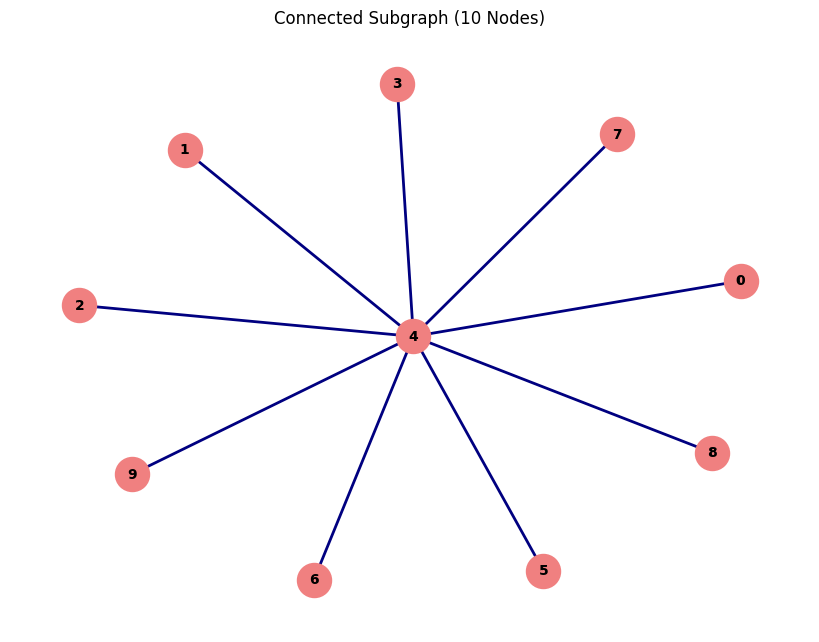

In [9]:
# Tạo đồ thị lớn có hướng
num_nodes = 1000
data = create_large_directed_graph(num_nodes=num_nodes, avg_degree=10, feature_dim=2)

sub_graph = extract_connected_subgraph(data, max_nodes=10, max_edges=20)

# Trực quan hóa subgraph
visualize_pyg_graph(
    sub_graph,
    title="Connected Subgraph (10 Nodes)",
    node_size=600,
    node_color='lightcoral',
    edge_color='navy',
    font_size=10,
    figsize=(8, 6),
    show_edge_labels=True
)

#4487133
#403244581